# pyPCGA modflow inversion example

Requirements : Flopy (tested in ver 3.2.9)

For Flopy installation and execution, please see http://www2.hawaii.edu/~jonghyun/classes/S18/CEE696/schedule.html

 

## Crosswell tomography

- Adapted from Application 1 of Lee and Kitanids [WRR 2014] 

(https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014WR015483)

***

> We first generated 870 head observations using crosswell pumping tests (ln 9) from the reference log K field (ln 11) with USGS MODFLOW Flopy python interface.

> In specific, we extracted groundwater at a well and observed 29 stready-state hydraulic heads at the remaining monitoring wells. We repeated these crosswell pumping tests for all 30 well locations (ln 11).  

> Then add the noise (std = 0.5) to observations. Using observations with MODFLOW, can we reconstruct the reference field (ln 11)?

Note the example is not exactly same as Application 1 in Lee and Kitanidis [2014]

Also, the number of MODFLOW simulations is higher than what they reported because we turned on Levenberg-Marquardt and Line Search options in this example. Those additional optimization routines increases the inversion time, but usually results in a very accurate inverse solution even for highly nonlinear problems. 

***

- Parameters

|Description           |                      |   Value |            
|----------------------|:----------------------------------:|:---------------------------:|
|*Geomteric parameters*                          | |       |                                               
| Lx, Ly        | Domain length and width [m]        |        1000, 750|         
| Q             | Pumping rates (m^2/d)              |            25 |           
| Rch           | Recharge rates (m/d)               |           0.001|          
| dx, dy        | Grid size [m]                      |            10|            
|*Geostatistical parameters*     ||                      |                        
| reference mean(logK)    | mean for the reference log K (ln m/d) |            2.5  |          
| reference q(x,x')       | Covariance kernel for the reference log K                  | q(x,x') = 0.002^3 (x-x')^3 |
| q(x,x')            | Covariance kernel used in inversion | q(x,x') = exp(-x/250) |
|*Measurement Error* ||  |
| nobs | Number of measurement | 870 |
| R | Variance of measurement error [m] | 0.5^2 |


In [1]:
from pathlib import Path
from typing import List, Tuple, Dict, Any
import logging
import os
import copy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import nested_grid_plotter as ngp
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import numpy as np  # need 1.21 at least

import pandas as pd


- Check package/software versions

In [ ]:
pyrtid.utils.show_verisons()

- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Set-up logging level

In [5]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a test")

INFO:root:this is a test


- Define some configurations for the plots

In [6]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a runner

In [7]:
if runner_type == RunnerType.FRONTAL:
    runner = FrontalHytecRunner(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        nb_cpu=4,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.SLURM:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=12,
        queue="geo-cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = SlurmHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.QSUB:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=12,
        queue="Omines_cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = QsubHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
else:
    raise Exception("Could not created runner")

- Grid definition

In [8]:
# Boundary definition
nx = 100
ny = 75
nz = 1
dx = 10
dy = 10
dz = 1

- Location of pumping wells (obs_locmat)

In [9]:
obs_locmat = np.zeros((nz, ny, nx), dtype=bool)
obs_locs: List[Tuple[int, int]] = []
for i in range(5, 71, 16):  # y
    for j in range(9, 96, 16):  # x
        obs_locmat[0, i, j] = 1
        obs_locs.append((j, i))

Q_locs_idx = np.where(obs_locmat == True)
Q_locs = []
for Q_loc in zip(Q_locs_idx[0], Q_locs_idx[1], Q_locs_idx[2]):
    Q_locs.append(Q_loc)

- x,y coordinates for plotting

In [10]:
x = np.linspace(0.0 + dx / 2.0, nx * dx - dx / 2.0, nx)
y = np.linspace(0.0 + dy / 2.0, ny * dy - dy / 2.0, ny)
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis]))

- Pumping/monitoring well locations

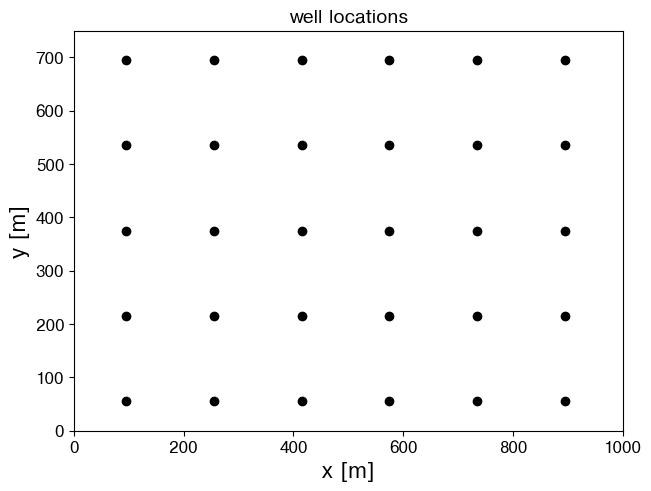

In [11]:
idx = np.where(obs_locmat == 1)
for i, j in zip(idx[1], idx[2]):
    plt.plot(x[j], y[i], "ko")
plt.xlim(0, nx * dx)
plt.ylim(0, ny * dy)
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("well locations")

fname = "well_locations"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- This example is Hydraulic tomography - crosswell pumping test setting
- Load reference value for comparison purpose with its plot

Note: in HYTEC, we can adjust the permeability, so we need to convert these values to permeability ones



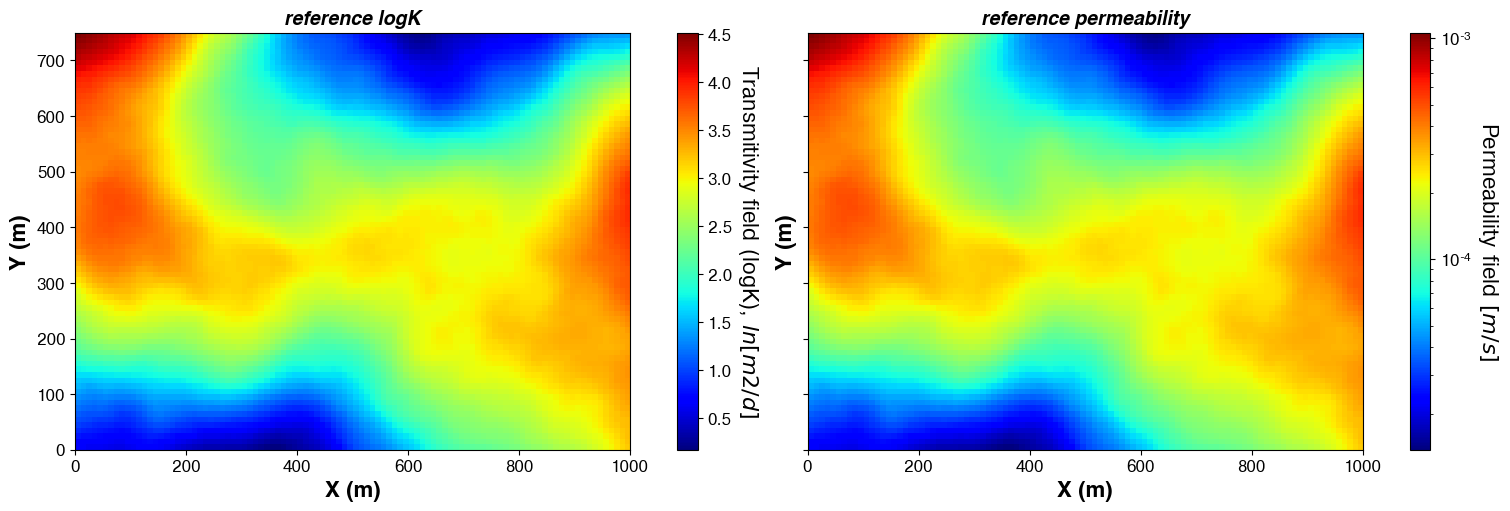

In [12]:
def log_transmitivity_to_permeability(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a transmitivity in ln[m2/d] to a permeability in [m/s]."""
    return np.exp(x) / 3600 / 24


def permeability_to_log_transmitivity(x: NDArrayFloat) -> NDArrayFloat:
    """Convert a permeability in [m/s] to a transmitivity in ln[m2/d]."""
    return np.log(x * 3600 * 24)


logT_reference: NDArrayFloat = np.loadtxt("reference_logK.txt")
perm_reference = log_transmitivity_to_permeability(logT_reference)
perm_reference_2d = perm_reference.reshape(ny, nx).T
logT_reference_3d = logT_reference.reshape(nz, ny, nx)
logT_reference_2d = logT_reference_3d[0, :, :].T

plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-1")],
    fig=plotter.fig,
    data={"reference logK": logT_reference_2d},
    cbar_title="Transmitivity field (logK), $ln[m2/d]$",
    imshow_kwargs={"cmap": plt.get_cmap("jet"), "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

ngp.multi_imshow(
    axes=[plotter.get_axis("ax1-2")],
    fig=plotter.fig,
    data={"reference permeability": perm_reference_2d},
    cbar_title="Permeability field $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

- Load observations (head) -> 30 wells = 30 pumping tests with 29 observations because we do no measure at the pumping well

In [13]:
obs_data: NDArrayFloat = np.loadtxt("obs.txt").reshape(30, -1)
obs_data.shape

(30, 29)

In [14]:
grid_obs = np.full((len(obs_locs), nx, ny), fill_value=np.nan, dtype=float)
for i, obs_loc in enumerate(obs_locs):
    j = 0
    for obs_loc2 in obs_locs:
        if obs_loc2 != obs_loc:
            grid_obs[i][obs_loc2] = obs_data[i][j]
            j += 1

# HYTEC MODEL

- Create an empty simulation in a non existing folder

In [15]:
simu_base = HytecSimulation("simu_base", Path.cwd().joinpath("simu_base"))

- Add a TDB file

In [16]:
simu_base.link_tdb("./../../../../TDB/chess.tdb")  # This is relative to the htc file

- Define the output format

In [17]:
simu_base.model.add_sub_item(hymd.OutputFormat("vtk"))

- Hydrodynamic model and its parameters definition


In [18]:
hmodel = hymd.HydrodynamicModel(
    hymd.FlowRegime("stationary"),
    hymd.Porosity(0.23),
    hymd.Permeability(8e-5, units="m/s"),
    hymd.DiffusionCoefficient(1e-4, units="m2/s"),
    hymd.Head(0.0, "m"),
    hymd.StorageCoefficient(1e-6),
)
simu_base.model.add_sub_item(hmodel)

- Geochemical unit definition

In [19]:
chmodel = hymd.GeochemicalModel(hymd.Report("full"), hymd.Redox("disabled"))
# Define a geochem unit
base_unit = hymd.GeochemicalUnit("chem_base")
species = "T"
# Set concentrations
base_unit.add_sub_item(hymd.Concentration(species, 0.0, units="molal"))
# define tracer
chmodel.add_sub_item(hymd.Define("basis", species))

# exclude
chmodel.add_sub_item(hymd.Exclude(("minerals", "colloids", "gases")))

# Add the units to the geochemical model
chmodel.add_sub_item(base_unit)

# Add to the main model
simu_base.model.add_sub_item(chmodel)

- Geometry definition

In [20]:
gmodel = hymd.GeometryModel(
    hymd.GridRegime("rectangle"), hymd.Domain(f"{nx*dx},{nx} {ny*dy},{ny}")
)
zone_domain = hymd.Zone(
    "domain",
    hymd.Geometry(f"rectangle {nx*dx / 2},{ny*dy/2} {nx*dx},{ny*dy}"),
    hymd.Geochemistry(base_unit.name),
)
gmodel.add_sub_item(zone_domain)
simu_base.model.add_sub_item(gmodel)

- Boundary model definition

In [21]:
flc_left = hymd.FlowCondition("constant-head at 120 m")
flc_right = hymd.FlowCondition("constant-head at 110 m")
bmodel = hymd.BoundaryModel(
    hymd.Boundary(
        "border_left", hymd.Coordinates(f"0,0, 0,{ny*dy}", units="m"), flc_left
    ),
    hymd.Boundary(
        "border_right",
        hymd.Coordinates(f"{nx*dx},{ny*dy}, {nx*dx},0", units="m"),
        flc_right,
    ),
)
simu_base.model.add_sub_item(bmodel)

- Time discretization

In [22]:
dt_in_days = 1
duration_in_days = 30
tmodel = hymd.TimeDiscretizationModel(
    hymd.Duration(duration_in_days, units="d"),
    hymd.TimeStep(
        hymd.Variable(
            hymd.StartValue(dt_in_days, "d"),
            hymd.Maximum(dt_in_days, "d"),
            hymd.CourantFactor(20.0),
        ),
    ),
)
simu_base.model.add_sub_item(tmodel)

- Sampling definition

In [23]:
# Sampling model
smodel = hymd.SamplingModel(
    hymd.GridSampling(30),
    hymd.Select("time", units="d"),
    hymd.Select("node-number"),
    hymd.Select("flowrate", units="m/s"),
    hymd.Select("permeability", units="m/s"),
    hymd.Select("head", units="m"),
    hymd.Select("T", units="mol/kg"),
)
simu_base.model.add_sub_item(smodel)

- Add a source term on the domain: aquifer recharge at 0.001 m/d = 0.001 * 7500 * 10 * 10 = 750 m3/d -> a bit more is required in HYTEC to get similar results

In [24]:
zone_domain.add_sub_item(hymd.Source(1000, "m3/d", geochem_unit=base_unit.name))

- Create the injection/pumping file: Only one well inject per day: 30 columns with 30 days + 1 column for the time (days) + 1 row for day 0 before any pumping

In [25]:
src_term_path: str = "MODIFY/source_terms.dat"
src_term_data: NDArrayFloat = np.zeros((len(obs_locs), len(obs_locs) + 1))
src_term_data[:, 0] = np.arange(30)

# Fill the diagonal with the pumping
np.fill_diagonal(src_term_data[:, 1:], -25)

# Add the aquifer recharge -> 1000 m3/d on the domain = 1000 / 7500 / 24 at the well

src_term_data[:, 1:] += 1000 / 7500 / 24
src_term_data

array([[ 0.00000000e+00, -2.49944444e+01,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03],
       [ 1.00000000e+00,  5.55555556e-03, -2.49944444e+01,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55555556e-03,  5.55555556e-03,
         5.55555556e-03,  5.55

In [26]:
# Add the producers with an imposed pumping of 25 m3/d
for count, (i, j) in enumerate(obs_locs):
    x = (i + 0.5) * dx
    y = (j + 0.5) * dy
    name = f"Producer_{i:0>2d}_{j:0>2d}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{y}, {dx/2},{dy/2}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))
    zone.add_sub_item(hymd.GlobalFlux(name))
    flowrate: float = 0.0
    if count == 0:
        flowrate = -25.0
    zone.add_sub_item(hymd.Source(flowrate, units="m3/h", geochem_unit=base_unit.name))
    zone.add_sub_item(
        hymd.Modify(
            "$1",
            hymd.Source(
                f"${count+2}",
                units=f"m3/h",
                geochem_unit=base_unit.name,
                src_file_path=src_term_path,
            ),
            time_units="d",
        )
    )
    simu_base.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)

# 3) Add the src_data_file (need to write and read the file... which is a bit stupid...)
# Register the source data file
simu_base.register_modifiy_src_file(src_term_path, src_term_data, fmt="%.3f")

- Create two models from this base simulation

In [27]:
simu_reference = copy.deepcopy(simu_base)
simu_reference.update_root_and_name(
    new_root="simu_reference", new_name="simu_reference"
)
simu_estimate = copy.deepcopy(simu_base)
simu_estimate.update_root_and_name(new_root="simu_estimate", new_name="simu_estimate")

- Add the permeability fields to the simulations

In [28]:
index: NDArrayInt = np.arange(nx * ny)

# True
data_true = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "y": sorted((index % ny) * dy + dy / 2),
        "permeability": perm_reference.ravel(),
    },  # need to flatten the parameter
    index=index,
)
simu_reference.add_param_file_data(ParameterFiles.HYDRO, data_true)

# Estimated
data_estimated = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "y": sorted((index % ny) * dy + dy / 2),
        "permeability": log_transmitivity_to_permeability(np.array([1.0])),
    },  # need to flatten the parameter
    index=index,
)
simu_estimate.add_param_file_data(ParameterFiles.HYDRO, data_estimated)

- Checking the hydro parameters have been correctly set-up

In [29]:
with pd.option_context("display.max_rows", 10):
    print(simu_reference.handlers.hydro.data)

      node-number      x      y  permeability
0               0    5.0    5.0      0.000022
1               1   15.0    5.0      0.000022
2               2   25.0    5.0      0.000022
3               3   35.0    5.0      0.000022
4               4   45.0    5.0      0.000021
...           ...    ...    ...           ...
7495         7495  955.0  745.0      0.000046
7496         7496  965.0  745.0      0.000046
7497         7497  975.0  745.0      0.000046
7498         7498  985.0  745.0      0.000046
7499         7499  995.0  745.0      0.000047

[7500 rows x 4 columns]


In [30]:
with pd.option_context("display.max_rows", 10):
    print(simu_estimate.handlers.hydro.data)

      node-number      x      y  permeability
0               0    5.0    5.0      0.000031
1               1   15.0    5.0      0.000031
2               2   25.0    5.0      0.000031
3               3   35.0    5.0      0.000031
4               4   45.0    5.0      0.000031
...           ...    ...    ...           ...
7495         7495  955.0  745.0      0.000031
7496         7496  965.0  745.0      0.000031
7497         7497  975.0  745.0      0.000031
7498         7498  985.0  745.0      0.000031
7499         7499  995.0  745.0      0.000031

[7500 rows x 4 columns]


In [31]:
simu_reference.handlers.modify_files.keys()

dict_keys([PosixPath('MODIFY/source_terms.dat')])

- Write input files and run simulations

In [32]:
simu_reference.write_input_files()
simu_estimate.write_input_files()
runner.run(simu_reference)
runner.run(simu_estimate)

The job is over ! Elapsed time = 0:00:06.438795
The job is over ! Elapsed time = 0:00:06.291716


True

- Read results

In [33]:
# Reference
simu_reference.read_hytec_results()
perm_reference_hytec: NDArrayFloat = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="permeability [m/s]", nx=nx, ny=ny
    )[:, :, 0, 0]
)
head_reference_hytec: NDArrayFloat = (
    simu_reference.handlers.results.extract_field_from_grid_res(
        field="head [m]", nx=nx, ny=ny
    )[:, :, 0, :]
)

# Initial guess
simu_estimate.read_hytec_results()
perm_estimate_hytec: NDArrayFloat = (
    simu_estimate.handlers.results.extract_field_from_grid_res(
        field="permeability [m/s]", nx=nx, ny=ny
    )[:, :, 0, 0]
)
head_estimate_hytec: NDArrayFloat = (
    simu_estimate.handlers.results.extract_field_from_grid_res(
        field="head [m]", nx=nx, ny=ny
    )[:, :, 0, :]
)

- Check that the permeability has been correctly defined in HYTEC (we see that from the grid results)

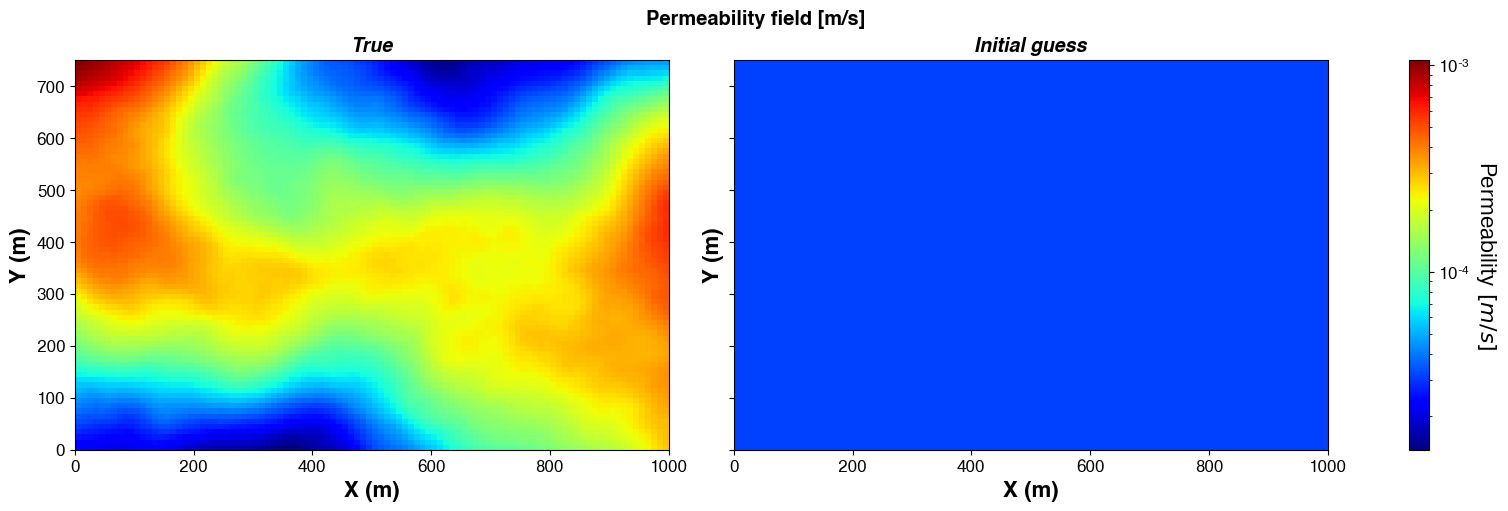

In [34]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Plot the permeability
ngp.multi_imshow(
    axes=[plotter.get_axis(ax_name) for ax_name in ["ax1-1", "ax1-2"]],
    fig=plotter.fig,
    data={"True": perm_reference_hytec, "Initial guess": perm_estimate_hytec},
    cbar_title="Permeability $[m/s]$",
    imshow_kwargs={
        "cmap": plt.get_cmap("jet"),
        "norm": LogNorm(),
        "extent": [0.0, nx * dx, 0.0, ny * dy],
    },
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Permeability field [m/s]", fontweight="bold")

fname = "perm_field_reference_vs_init"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Plot a sample

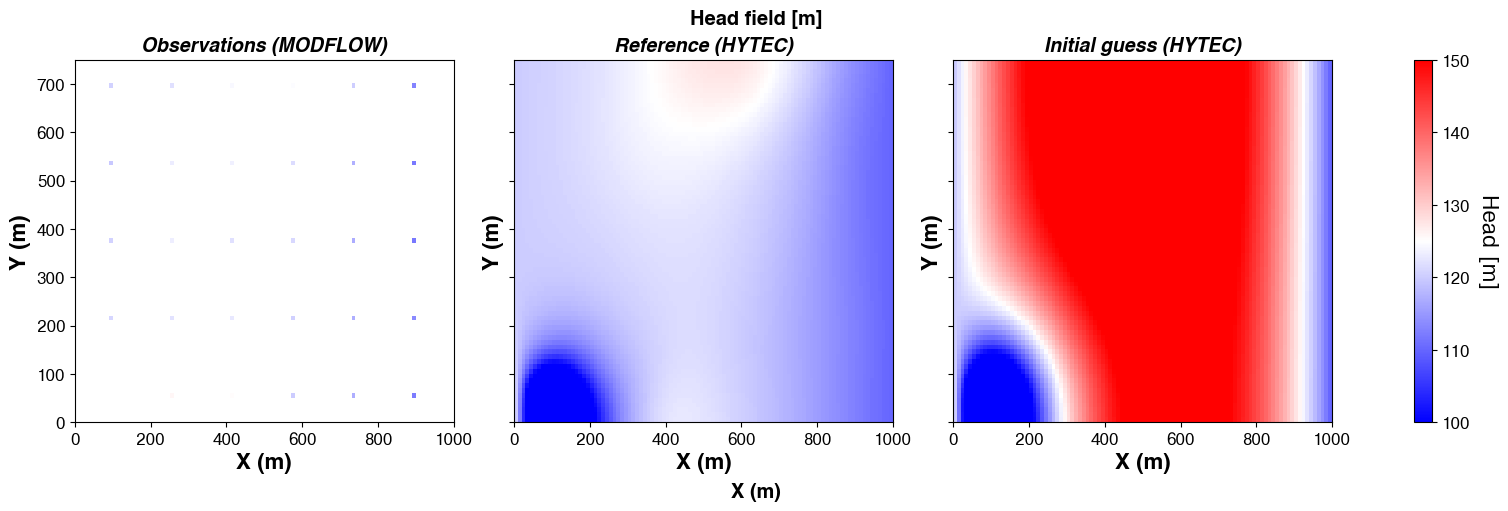

In [35]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

well_id = 0
ngp.multi_imshow(
    axes=[plotter.get_axis(ax_name) for ax_name in ["ax1-1", "ax1-2", "ax1-3"]],
    data={
        # Warning: observation 0 matches sample 1
        "Observations (MODFLOW)": grid_obs[well_id],
        "Reference (HYTEC)": head_reference_hytec[:, :, well_id + 1],
        "Initial guess (HYTEC)": head_estimate_hytec[:, :, well_id + 1],
    },
    fig=plotter.fig,
    cbar_title="Head [m]",
    imshow_kwargs={"vmin": 100, "vmax": 150, "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")
plotter.subfigs["fig0"].supxlabel("X [m]", fontweight="bold")

fname = "head_field_reference_vs_initial_guess"
for format in ["png", "pdf"]:
    plotter.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Make an animated version

In [36]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (15, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2", "ax1-3"]], sharey=True, sharex=True)
    },
)

nb_frames = grid_obs.shape[0]
plotter.animated_multi_imshow(
    ax_names=["ax1-1", "ax1-2", "ax1-3"],
    data={
        # Warning: observation 0 matches sample 1
        "Observations (MODFLOW)": np.transpose(grid_obs, axes=(1, 2, 0)),
        "Reference (HYTEC)": head_reference_hytec[:, :, 1:],
        "Initial guess (HYTEC)": head_estimate_hytec[:, :, 1:],
    },
    cbar_title="Head [m]",
    nb_frames=nb_frames,
    imshow_kwargs={"vmin": 100, "vmax": 150, "extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.subfigs["fig0"].suptitle("Head field [m]", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath(
    "head_field_reference_vs_initial_guess_animated.html"
)
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Compare the data from HYTEC with the one from MODFLOW for the "reference" model

In [37]:
pumping_test_id = 5  # index of the well pumping test

dat_modflow: NDArrayFloat = np.zeros(len(obs_locs))
dat_hytec_reference: NDArrayFloat = np.zeros(len(obs_locs))
dat_hytec_estimate: NDArrayFloat = np.zeros(len(obs_locs))

for i, obs_loc in enumerate(obs_locs):
    dat_modflow[i] = grid_obs[pumping_test_id][obs_loc[0], obs_loc[1]]
    dat_hytec_reference[i] = head_reference_hytec[:, :, pumping_test_id][
        obs_loc[0], obs_loc[1]
    ]
    dat_hytec_estimate[i] = head_estimate_hytec[:, :, pumping_test_id][
        obs_loc[0], obs_loc[1]
    ]

plt.plot(dat_modflow, label="modflow")
plt.plot(dat_hytec_reference, label="hytec reference")
plt.plot(dat_hytec_estimate, label="hytec estimate")
plt.legend()

fname = f"heads_modflow_vs_hytec_for_pumping_test_{pumping_test_id}"
for format in ["png", "pdf"]:
    plt.savefig(str(fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Compare the same data but looked at a specific well location

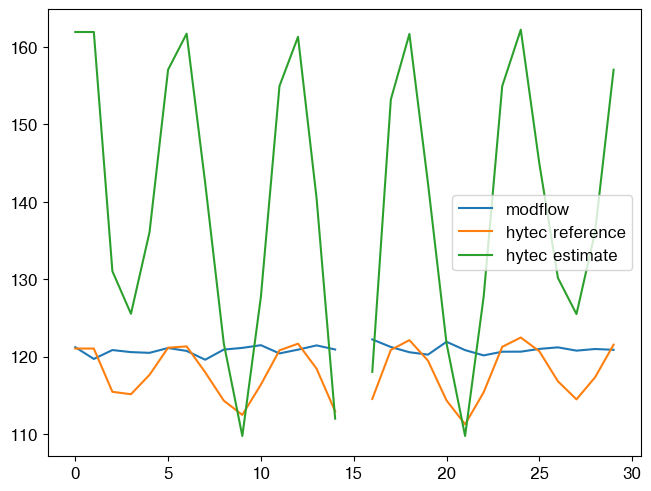

In [54]:
well_id = 15  # index of the well pumping test

obs_loc = obs_locs[well_id]
dat_modflow = grid_obs[:, obs_loc[0], obs_loc[1]]
dat_hytec_reference = head_reference_hytec[
    obs_loc[0], obs_loc[1], 1:
]  # We do not count time 0
dat_hytec_reference[well_id] = np.nan  # Exclude the day of pumping
dat_hytec_estimate = head_estimate_hytec[
    obs_loc[0], obs_loc[1], 1:
]  # We do not count time 0
dat_hytec_estimate[well_id] = np.nan  # Exclude the day of pumping

plt.plot(dat_modflow, label="modflow")
plt.plot(dat_hytec_reference, label="hytec reference")
plt.plot(dat_hytec_estimate, label="hytec estimate")
plt.legend()

## Inversion

- Create a function to add some noise to the observations

In [39]:
noise_std = 0.3  # This is an absolute value -> 0.3 m std for the head
rng = np.random.default_rng(2021)


def make_noisy(x: np.ndarray) -> np.ndarray:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + rng.normal(mean_noise, noise_std, x.shape)

- Check the intensity of the noise

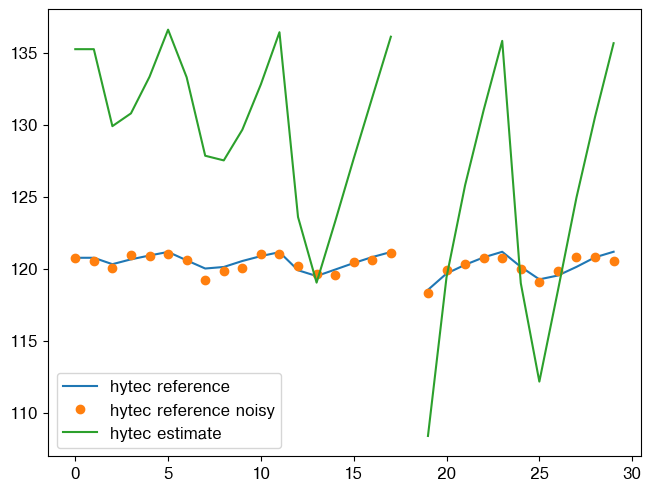

In [40]:
plt.plot(dat_hytec_reference, label="hytec reference")
plt.plot(
    make_noisy(dat_hytec_reference),
    label="hytec reference noisy",
    linestyle="None",
    marker="o",
)
plt.plot(dat_hytec_estimate, label="hytec estimate")
plt.legend()

- Copy the base estimate

In [41]:
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

- Add the observation data at the wells positions


In [42]:
for count, (i, j) in enumerate(obs_locs):
    x = (i + 0.5) * dx
    y = (j + 0.5) * dy
    zone_name = f"Producer_{i:0>2d}_{j:0>2d}"

    vals = make_noisy(head_reference_hytec[i, j, 1:])
    vals[count] = np.nan

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable="head",
        units="m",
        timesteps=np.arange(1, 31),
        time_units="d",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size)
        * indices_to_hytec_node_number(ix=i, nx=nx, iy=j),
    )
    simu_inverse.register_observable(
        zone_name, obs, obs_file_path=f"observables/{zone_name}_o.dat"
    )

- Check that the observations have been correctly passed to the estimated model 

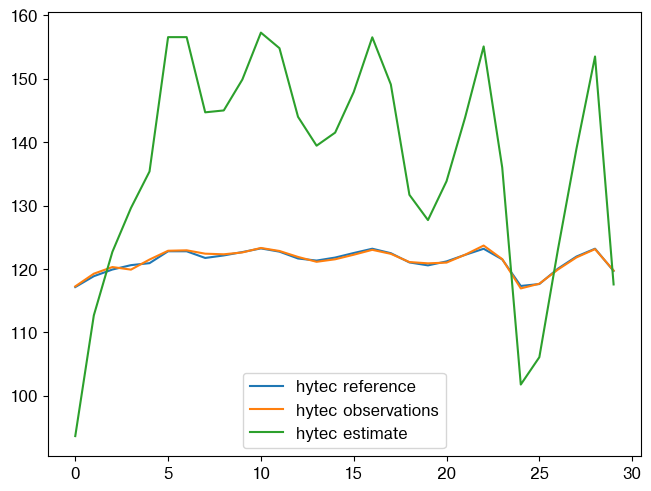

In [43]:
# Observation vector from HYTEC -> transform it to achieve PCGA expected shape
obs_hytec_reference: NDArrayFloat = (
    simu_inverse.get_observation_vector()
)  # .reshape(len(simu_estimate.get_adjustable_parameters()), -1).T.ravel()
res_hytec_reference: NDArrayFloat = simu_reference.get_results_matching_obs_vector(
    simu_inverse.get_observables()
)
res_hytec_estimate: NDArrayFloat = simu_estimate.get_results_matching_obs_vector(
    simu_inverse.get_observables()
)

well_id = 24  # indew of the well we look at

dat = grid_obs[:, obs_locs[well_id][0], obs_locs[well_id][1]]

plt.plot(res_hytec_reference.reshape(29, -1)[well_id], label="hytec reference")
plt.plot(obs_hytec_reference.reshape(29, -1)[well_id], label="hytec observations")
plt.plot(res_hytec_estimate.reshape(29, -1)[well_id], label="hytec estimate")
plt.legend()

# Inversion without regularization

- Compute the objective function

In [44]:
obj = 1 / 2 * np.sum(np.square((obs_hytec_reference - res_hytec_estimate) / noise_std))
logging.info(f"objective function (SSE)= {obj}")

INFO:root:objective function (SSE)= 2085814.3829884802


- Create a simulation for inversion and compute the first gradient

In [45]:
# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointStateStatus("enabled"),
        hymd.MaxNumberIterations(1),
        hymd.MaxNumberGradientEval(1),
        hymd.MaxNumberFwdModelEval(1),
    ),
    hymd.AdjustedParameterConfig(
        "permeability",
        hymd.Lbound(1e-6, units="m/s"),
        hymd.Ubound(1e-1, units="m/s"),
        hymd.Preconditioner("logarithmic"),
    ),
)
simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(30)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written


# # 2) Update the htc file with some options
# simu_inverse.handlers.htc.optimization = "enabled"
# simu_inverse.handlers.htc.optimization_solver = OptimizationSolverConfig(
#     solver_name="lbfgsb",
#     max_number_iterations=1,
#     max_number_fwd_model_eval=10,
#     max_number_gradient_eval=1,
#     max_number_hessian_eval=1,
#     objfun_threshold=1e-1,
#     objfun_min_change=0.0,
#     param_min_change=0.0,
#     gradient_min_norm=0.0,
#     hessian_max_norm=0.0,
#     grad_history_size=10,
#     adjoint_state="enabled",
#     fd_gradient_check="disabled",
# )

The job is over ! Elapsed time = 0:00:14.718464


- Extract the adjoint variables computed for the first gradient

In [46]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

columns = ['timestep', 'Zones', 'node-number []', 'adjoint-variable{head} []', 'x-distance', 'y-distance']


In [47]:
adj_head_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{head} []", nx=nx, ny=ny
)
adj_head_hytec.shape

(100, 75, 1, 31)

- Plot the adjoint head

In [48]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (7, 5)},
)

nb_frames = grid_obs.shape[0]

plotter.animated_multi_imshow(
    ax_names=["ax1-1"],
    data={
        "Adjoint head": adj_head_hytec[:, :, 0, :],
    },
    cbar_title="Adjoit head",
    nb_frames=nb_frames,
    imshow_kwargs={"extent": [0.0, nx * dx, 0.0, ny * dy]},
    xlabel="X [m]",
    ylabel="Y [m]",
)

plotter.fig.suptitle("Adjoint head", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)

# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("adjoint_head_field_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


- Plot the first gradient

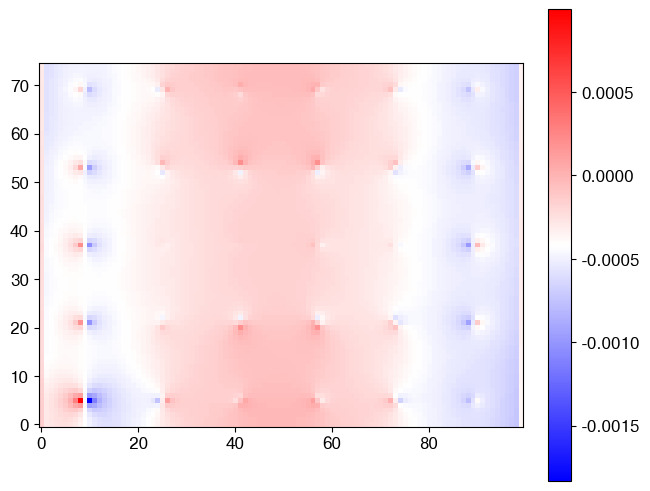

In [49]:
# Get the HYTEC  Adj gradient
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

plt.imshow(
    hytec_adjoint_gradient["value"].to_numpy().reshape(ny, nx),
    origin="lower",
    # norm=LogNorm(vmin=1e-5, vmax=1e-3),
    cmap=plt.get_cmap("bwr"),
)
plt.colorbar()

# Inversion with regularization

- TODO: 